![Practicum AI Logo image](https://github.com/PracticumAI/practicumai.github.io/blob/main/images/logo/PracticumAI_logo_250x50.png?raw=true) <img src="https://github.com/PracticumAI/practicumai.github.io/blob/84b04be083ca02e5c7e92850f9afd391fc48ae2a/images/icons/practicumai_computer_vision.png?raw=true" alt="Practicum AI: Computer Vision icon" align="right" width=50>
***

# Handling Data Imbalance in Computer Vision

<img src='images/data_imbalance_histogram.png' alt='Histogram of the data imbalance in the bees vs wasp dataset showing that there are many more images of wasps than other categories.' align='right'>

Welcome to the fourth notebook in our Computer Vision series! In the previous notebooks, we've been working with a **subsampled** version of the bee vs wasp dataset that was relatively balanced across classes. However, real-world datasets often suffer from **class imbalance** - where some classes have significantly more examples than others.

In this notebook, we'll:
1. Work with the **full** bee vs wasp dataset (not the subsampled version)
2. Explore the class imbalance problem
3. Learn techniques to handle imbalanced data using PyTorch Lightning
4. Compare model performance with and without imbalance handling techniques

### What is Class Imbalance?

Class imbalance occurs when the number of samples in different classes varies significantly. For example:
- Class A: 1000 samples
- Class B: 100 samples  
- Class C: 50 samples
- Class D: 10 samples

This imbalance can cause models to:
- **Bias toward majority classes**: The model learns to predict the most common class more often
- **Poor performance on minority classes**: Rare classes get insufficient training examples
- **Misleading accuracy metrics**: High overall accuracy can hide poor performance on important minority classes

### Techniques for Handling Class Imbalance

We'll explore several approaches:
1. **Weighted Random Sampling**: Oversample minority classes during training
2. **Class Weights in Loss Function**: Give higher penalty for misclassifying minority classes
3. **Evaluation Metrics**: Use metrics that account for class imbalance (precision, recall, F1-score)

### The Lazy Student

One way people explain data imbalance is using an analogy to a lazy student. Imagine that a professor makes a multiple choice test, and a student has figured out that the professor uses "C" as the correct answer 95% of the time. Why study for the test? The student can get a 95% just by answering "C" for all questions. 

Similarly, with unbalanced data, the model can look like it's performing well--scoring a 95% accuracy for example--when in reality, it simply classifies every input as belonging to a class that represents 95% of the overall data. 

## 1. Import Libraries and Setup

In [1]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
import matplotlib.pyplot as plt
import numpy as np
import os
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# Import our helper functions
import helpers_01

# Set seed for reproducibility
pl.seed_everything(42)

print(f"PyTorch version: {torch.__version__}")
print(f"PyTorch Lightning version: {pl.__version__}")
print(f"CUDA available: {torch.cuda.is_available()}")

[rank: 0] Seed set to 42


PyTorch version: 2.7.1+cu128
PyTorch Lightning version: 2.5.1.post0
CUDA available: True


## 2. Set Number of Workers for Data Loading

In [2]:
# Set the number of workers to use for data loading
num_workers = None  # To manually set the number of workers, change this to an integer

if num_workers is None:
    # If Slurm is being used, set the number of workers to a Slurm-provided value.
    # If Slurm is not being used, set the number of workers to the number of available CPU cores.
    if os.getenv("SLURM_CPUS_PER_TASK") is not None:
        num_workers = int(os.getenv("SLURM_CPUS_PER_TASK"))
    elif os.getenv("SLURM_NTASKS_PER_NODE") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS_PER_NODE"))
    elif os.getenv("SLURM_NTASKS") is not None:
        num_workers = int(os.getenv("SLURM_NTASKS"))
    else:
        num_workers = os.cpu_count()

print(f"Using {num_workers} workers for data loading.")

Using 4 workers for data loading.


## 3. Load the Full (Imbalanced) Dataset

Now we'll load the **full** bee vs wasp dataset, which contains the natural class imbalance. This is different from the subsampled dataset used in previous notebooks.

In [3]:
# Get the full dataset (not the subsampled version)
full_data_path = helpers_01.manage_full_data(
    folder_name="bee_vs_wasp",
)

Found data at: data/bee_vs_wasp


## 4. Explore the Class Imbalance

Let's first load the data **without** any imbalance handling to see the natural distribution of classes.

Before we proceed, we'll validate that the dataset is properly structured and accessible.

> **NOTE:** Since the dataset used here is much bigger, many of the cells in this notebook will take some time to run.

******************************************************************
Load imbalanced data:
  - Loading the dataset from: data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 4 workers for data loading
  - Using weighted sampler: False
******************************************************************

Class distribution in the full dataset:
   Class                # of images     % of total
--------------------------------------------------------
   bee                 3183       27.9%
   other_insect        2439       21.4%
   other_noinsect       856        7.5%
   wasp                4943       43.3%
--------------------------------------------------------
   Total                  11421     100.0%


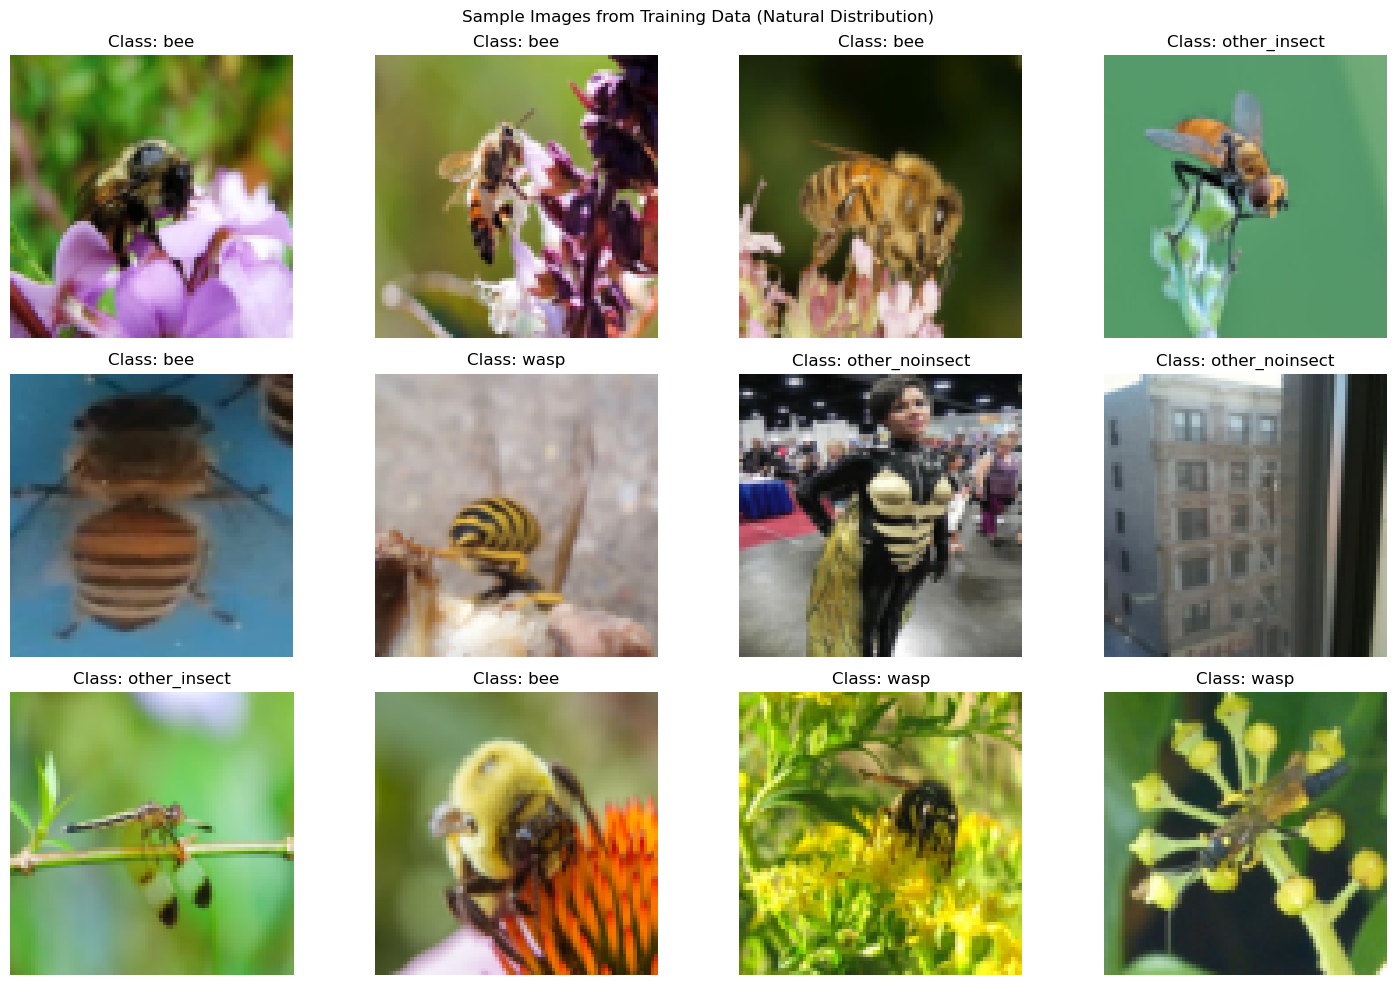

In [4]:
# Load data without weighted sampling to see the natural imbalance
data_module_unbalanced = helpers_01.load_imbalanced_data(
    full_data_path,
    batch_size=32,
    shape=(80, 80, 3),
    show_pictures=True,
    train_split=0.8,
    num_workers=num_workers,
    use_weighted_sampler=False,  # No weighted sampling to see natural distribution
)

As you can see, the dataset is highly imbalanced! Some classes have thousands of images while one has only hundreds. This imbalance can significantly impact model performance.

## 5. Train a Baseline Model (No Imbalance Handling)

Let's first train a model without any imbalance handling techniques to establish a baseline.

TRAINING BASELINE MODEL (No Imbalance Handling)


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | dropout        | Dropout            | 0      | train
4 | relu           | ReLU               | 0      | train
5 | fc1            | Linear             | 3.3 M  | train
6 | fc2            | Linear             | 516    | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Baseline Model Results:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7431071996688843
        test_loss           0.9659250378608704
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 7 points
Processing tag: val_acc
Found val acc: val_acc with 7 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 7 points
Processing tag: train_acc
Found train acc: train_acc with 7 points

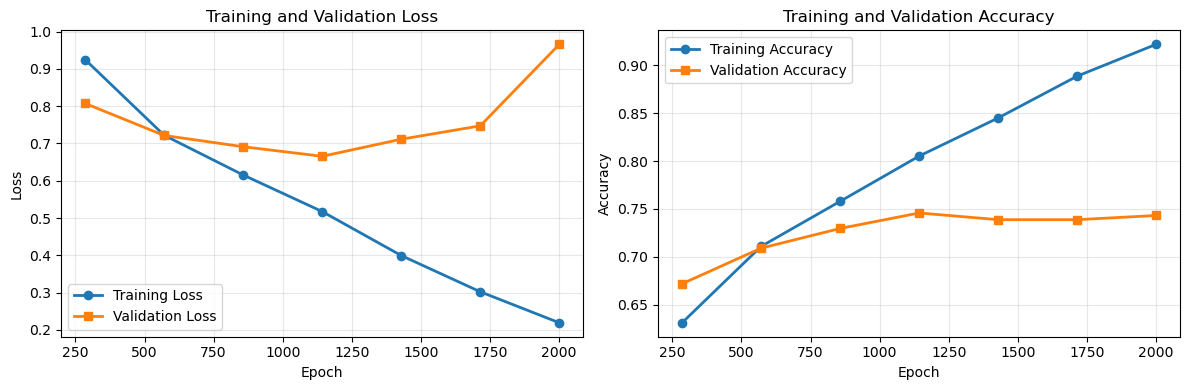

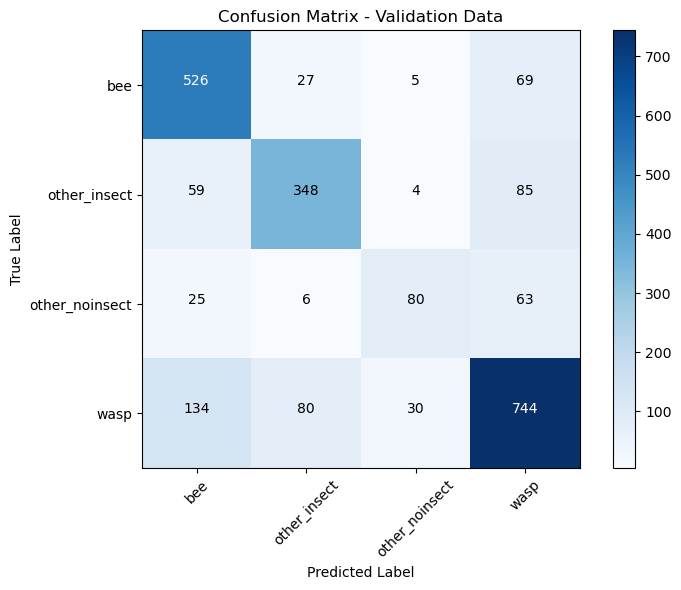


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.707, Recall=0.839, F1=0.767
   other_insect: Precision=0.755, Recall=0.702, F1=0.727
 other_noinsect: Precision=0.672, Recall=0.460, F1=0.546
           wasp: Precision=0.774, Recall=0.753, F1=0.763


In [5]:
print("=" * 60)
print("TRAINING BASELINE MODEL (No Imbalance Handling)")
print("=" * 60)

# Train baseline model without imbalance handling
baseline_model, baseline_trainer = helpers_01.train_model(
    data_module=data_module_unbalanced,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    input_shape=(3, 80, 80),
    dropout_rate=0.3,
)

print("\nBaseline Model Results:")
baseline_results = helpers_01.test_model(
    data_module_unbalanced, baseline_model, baseline_trainer
)

## 6. Train Model with Weighted Random Sampling

Now let's train a model using **weighted random sampling**. This technique oversamples minority classes during training so the model sees a more balanced distribution of examples.

Note: We'll load the data again but won't show the class distribution since we already saw it above.

******************************************************************
Load imbalanced data:
  - Loading the dataset from: data/bee_vs_wasp.
  - Using a batch size of: 32.
  - Resizing input images to: (80, 80, 3).
  - Train/validation split: 80.0%/20.0%
  - Using 4 workers for data loading
  - Using weighted sampler: True
******************************************************************


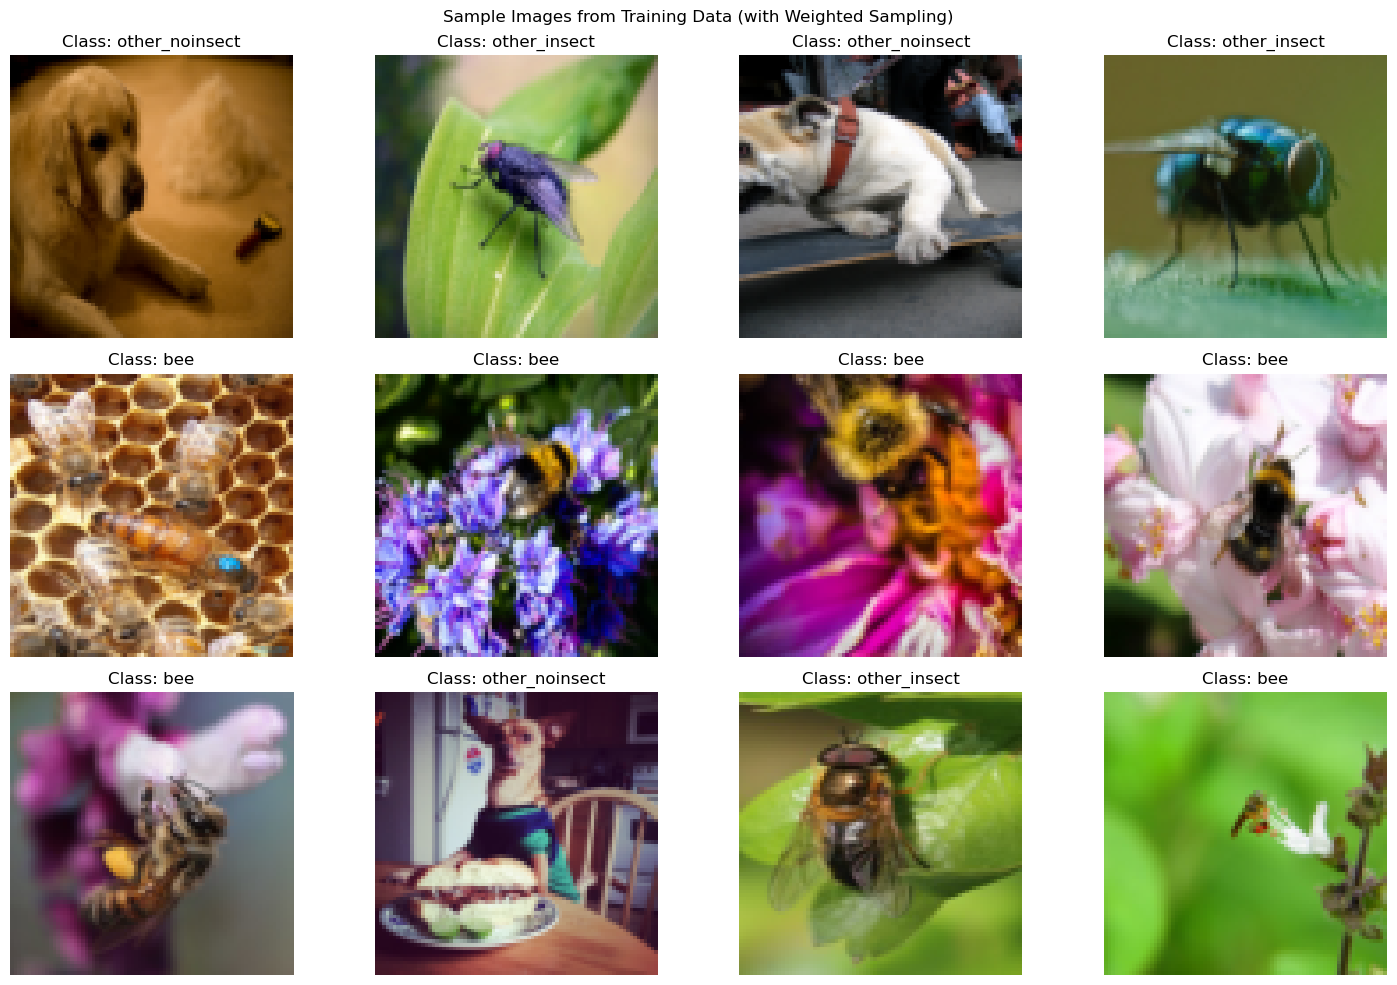

In [6]:
# Load data WITH weighted sampling to handle imbalance
data_module_weighted = helpers_01.load_imbalanced_data(
    full_data_path,
    batch_size=32,
    shape=(80, 80, 3),
    show_pictures=True,
    train_split=0.8,
    num_workers=num_workers,
    use_weighted_sampler=True,  # Enable weighted sampling
    show_class_distribution=False,  # Don't show distribution again
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs


TRAINING MODEL WITH WEIGHTED SAMPLING


/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | dropout        | Dropout            | 0      | train
4 | relu           | ReLU               | 0      | train
5 | fc1            | Linear             | 3.3 M  | train
6 | fc2            | Linear             | 516    | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccuracy | 0      | train
9 | test_accuracy  | MulticlassAccuracy | 0      | train
-------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Weighted Sampling Model Results:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7431071996688843
        test_loss           0.8335251808166504
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'train_loss_step', 'epoch', 'val_loss', 'val_acc', 'train_loss_epoch', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: train_loss_step
Processing tag: epoch
Processing tag: val_loss
Found val loss: val_loss with 8 points
Processing tag: val_acc
Found val acc: val_acc with 8 points
Processing tag: train_loss_epoch
Found train loss: train_loss_epoch with 8 points
Processing tag: train_acc
Found train acc: train_acc with 8 points

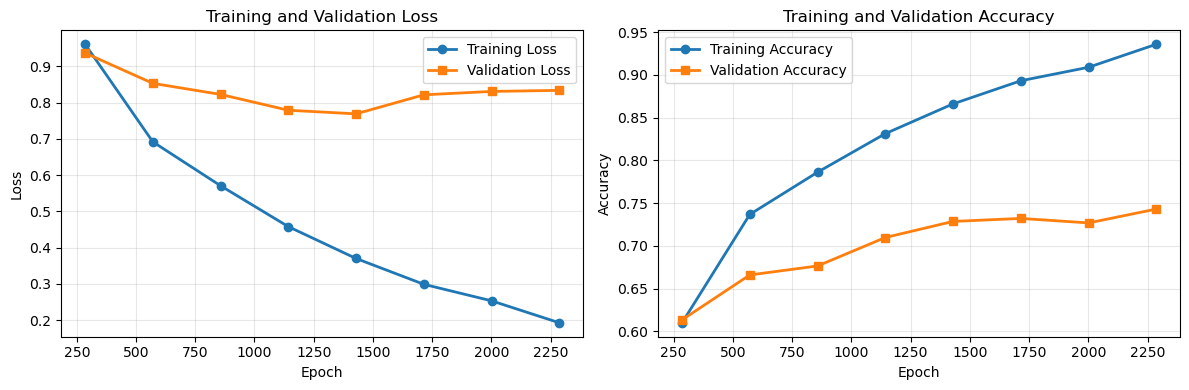

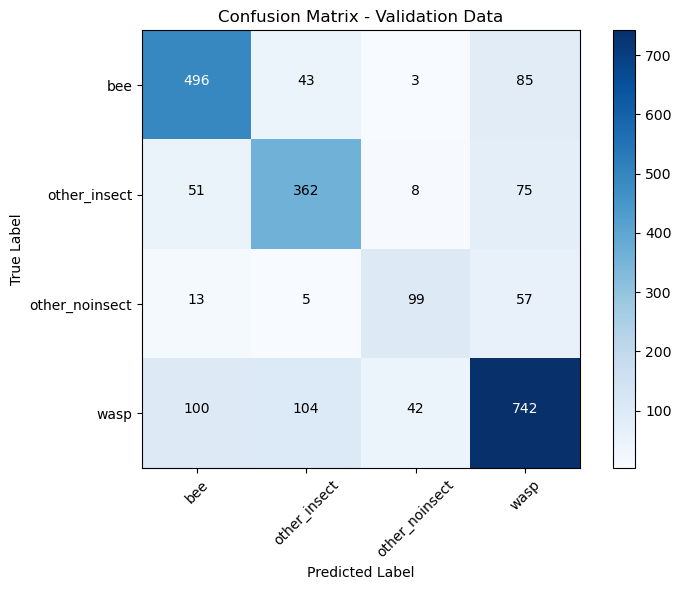


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.752, Recall=0.791, F1=0.771
   other_insect: Precision=0.704, Recall=0.730, F1=0.717
 other_noinsect: Precision=0.651, Recall=0.569, F1=0.607
           wasp: Precision=0.774, Recall=0.751, F1=0.762


In [7]:
print("=" * 60)
print("TRAINING MODEL WITH WEIGHTED SAMPLING")
print("=" * 60)

# Train model with weighted sampling
weighted_model, weighted_trainer = helpers_01.train_model(
    data_module=data_module_weighted,
    num_classes=4,
    learning_rate=0.001,
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    input_shape=(3, 80, 80),
    dropout_rate=0.3,
)

print("\nWeighted Sampling Model Results:")
weighted_results = helpers_01.test_model(
    data_module_weighted, weighted_model, weighted_trainer
)

## 7. Train Model with Class Weights in Loss Function

Another approach is to use **class weights** in the loss function. This gives higher penalty for misclassifying minority classes.

In [9]:
# Create a model with weighted loss function
class WeightedLossCNN(helpers_01.SimpleCNN):
    """CNN model with weighted loss function for handling class imbalance"""

    def __init__(
        self,
        num_classes=4,
        learning_rate=0.001,
        input_shape=(3, 80, 80),
        dropout_rate=0.3,
        conv_padding=1,
        class_weights=None,
    ):
        super().__init__(
            num_classes, learning_rate, input_shape, dropout_rate, conv_padding
        )

        # Store class weights for loss function
        if class_weights is not None:
            self.register_buffer("class_weights", class_weights)
        else:
            self.class_weights = None

    def training_step(self, batch, batch_idx):
        x, y = batch
        logits = self(x)

        # Use weighted loss if class weights are provided
        if self.class_weights is not None:
            loss_fn = nn.CrossEntropyLoss(weight=self.class_weights)
        else:
            loss_fn = nn.CrossEntropyLoss()

        loss = loss_fn(logits, y)

        # Calculate accuracy
        preds = torch.argmax(logits, dim=1)
        acc = (preds == y).float().mean()

        # Log metrics
        self.log("train_loss", loss, on_step=False, on_epoch=True, prog_bar=True)
        self.log("train_acc", acc, on_step=False, on_epoch=True, prog_bar=True)

        return loss


# Calculate class weights based on inverse frequency
class_names, class_counts = data_module_unbalanced.get_class_info()
total_samples = sum(class_counts.values())
num_classes = len(class_names)

class_weights = []
for class_name in class_names:
    weight = total_samples / (num_classes * class_counts[class_name])
    class_weights.append(weight)

class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32)
print(f"Calculated class weights: {class_weights_tensor}")

Calculated class weights: tensor([0.8970, 1.1707, 3.3356, 0.5776])


TRAINING MODEL WITH WEIGHTED LOSS FUNCTION


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/blue/ufhpc/magitz/conda/envs/pt_lightning/lib/python3.12/site-packages/pytorch_lightning/callbacks/model_checkpoint.py:654: Checkpoint directory /blue/ufhpc/magitz/PracticumAI/computer_vision/checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type               | Params | Mode 
--------------------------------------------------------------
0 | conv1          | Conv2d             | 896    | train
1 | conv2          | Conv2d             | 18.5 K | train
2 | pool           | MaxPool2d          | 0      | train
3 | dropout        | Dropout            | 0      | train
4 | relu           | ReLU               | 0      | train
5 | fc1            | Linear             | 3.3 M  | train
6 | fc2            | Linear             | 516    | train
7 | train_accuracy | MulticlassAccuracy | 0      | train
8 | val_accuracy   | MulticlassAccu

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]


Weighted Loss Model Results:


LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
SLURM auto-requeueing enabled. Setting signal handlers.


Testing: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
       Test metric             DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
        test_acc            0.7514223456382751
        test_loss           0.7448859810829163
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
Available scalar tags: ['hp_metric', 'val_loss', 'val_acc', 'epoch', 'train_loss', 'train_acc', 'test_loss', 'test_acc']
Processing tag: hp_metric
Processing tag: val_loss
Found val loss: val_loss with 8 points
Processing tag: val_acc
Found val acc: val_acc with 8 points
Processing tag: epoch
Processing tag: train_loss
Found train loss: train_loss with 8 points
Processing tag: train_acc
Found train acc: train_acc with 8 points
Processing tag: test_loss
Processing tag: test_acc


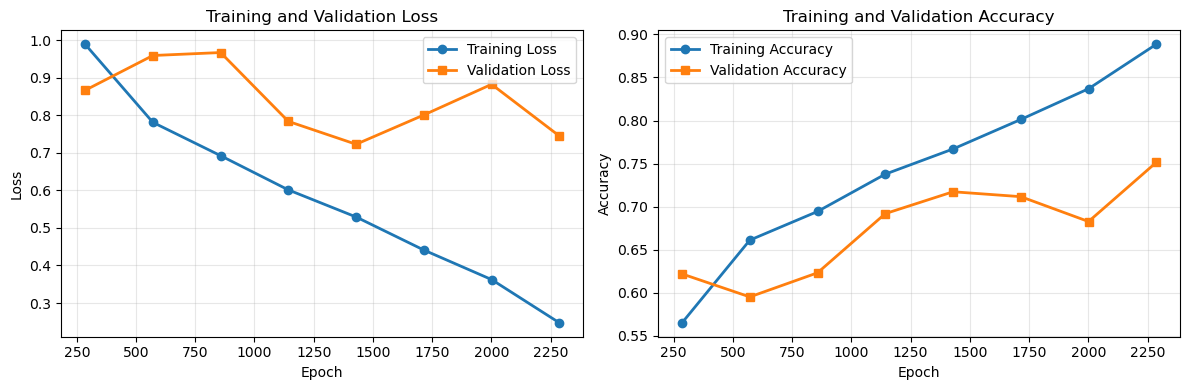

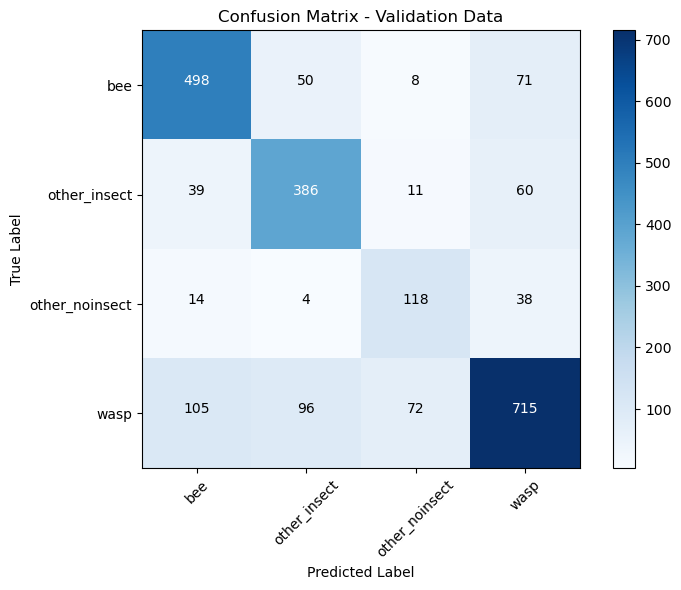


Per-class Performance:
--------------------------------------------------
            bee: Precision=0.759, Recall=0.794, F1=0.776
   other_insect: Precision=0.720, Recall=0.778, F1=0.748
 other_noinsect: Precision=0.565, Recall=0.678, F1=0.616
           wasp: Precision=0.809, Recall=0.724, F1=0.764


In [10]:
print("=" * 60)
print("TRAINING MODEL WITH WEIGHTED LOSS FUNCTION")
print("=" * 60)

# Create model with weighted loss
weighted_loss_model = WeightedLossCNN(
    num_classes=4,
    learning_rate=0.001,
    input_shape=(3, 80, 80),
    dropout_rate=0.3,
    class_weights=class_weights_tensor,
)

# Create trainer
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import ModelCheckpoint, EarlyStopping

logger = TensorBoardLogger("lightning_logs", name="weighted_loss_experiment")

early_stopping = EarlyStopping(
    monitor="val_loss", patience=3, verbose=False, mode="min"
)

checkpoint_callback = ModelCheckpoint(
    monitor="val_acc",
    dirpath="checkpoints/",
    filename="weighted-loss-best-checkpoint",
    save_top_k=1,
    mode="max",
)

weighted_loss_trainer = pl.Trainer(
    max_epochs=10,
    accelerator="auto",
    devices="auto",
    logger=logger,
    callbacks=[early_stopping, checkpoint_callback],
    enable_progress_bar=True,
    enable_model_summary=True,
)

# Train the model (use unbalanced data module since we're handling imbalance in the loss function)
weighted_loss_trainer.fit(weighted_loss_model, datamodule=data_module_unbalanced)

print("\nWeighted Loss Model Results:")
weighted_loss_results = helpers_01.test_model(
    data_module_unbalanced, weighted_loss_model, weighted_loss_trainer
)

## 8. Detailed Evaluation and Comparison

Let's create a comprehensive comparison of all three approaches using detailed metrics that are appropriate for imbalanced datasets.


COMPREHENSIVE MODEL COMPARISON

Baseline (No Imbalance Handling) - Detailed Evaluation:
Classification Report:
                precision    recall  f1-score   support

           bee      0.707     0.839     0.767       627
  other_insect      0.755     0.702     0.727       496
other_noinsect      0.672     0.460     0.546       174
          wasp      0.774     0.753     0.763       988

      accuracy                          0.743      2285
     macro avg      0.727     0.688     0.701      2285
  weighted avg      0.744     0.743     0.740      2285



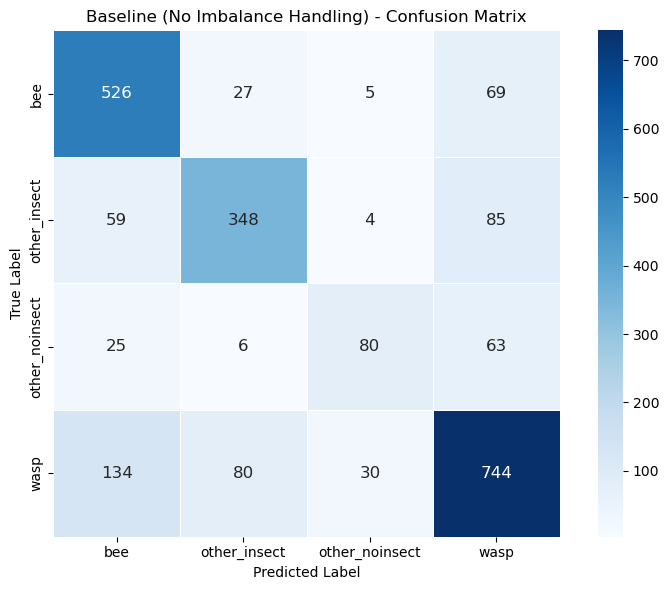


Per-class Accuracy:
  bee: 0.839
  other_insect: 0.702
  other_noinsect: 0.460
  wasp: 0.753

Weighted Sampling - Detailed Evaluation:
Classification Report:
                precision    recall  f1-score   support

           bee      0.752     0.791     0.771       627
  other_insect      0.704     0.730     0.717       496
other_noinsect      0.651     0.569     0.607       174
          wasp      0.774     0.751     0.762       988

      accuracy                          0.744      2285
     macro avg      0.720     0.710     0.714      2285
  weighted avg      0.743     0.744     0.743      2285



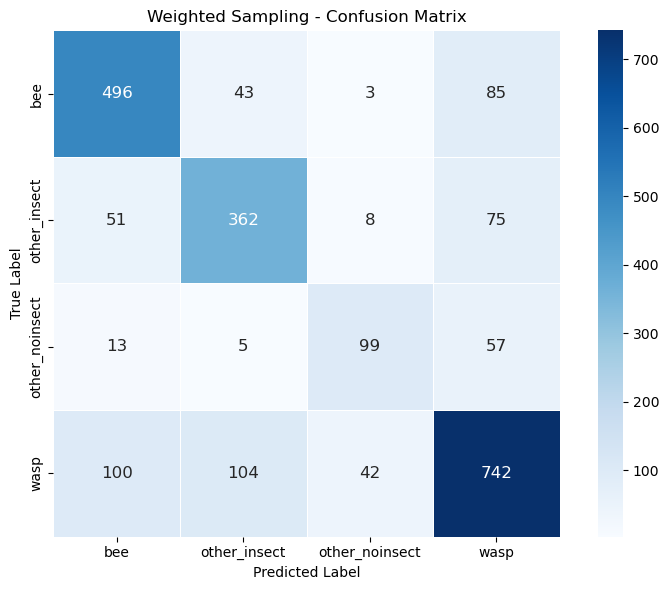


Per-class Accuracy:
  bee: 0.791
  other_insect: 0.730
  other_noinsect: 0.569
  wasp: 0.751

Weighted Loss Function - Detailed Evaluation:
Classification Report:
                precision    recall  f1-score   support

           bee      0.759     0.794     0.776       627
  other_insect      0.720     0.778     0.748       496
other_noinsect      0.565     0.678     0.616       174
          wasp      0.809     0.724     0.764       988

      accuracy                          0.751      2285
     macro avg      0.713     0.744     0.726      2285
  weighted avg      0.757     0.751     0.753      2285



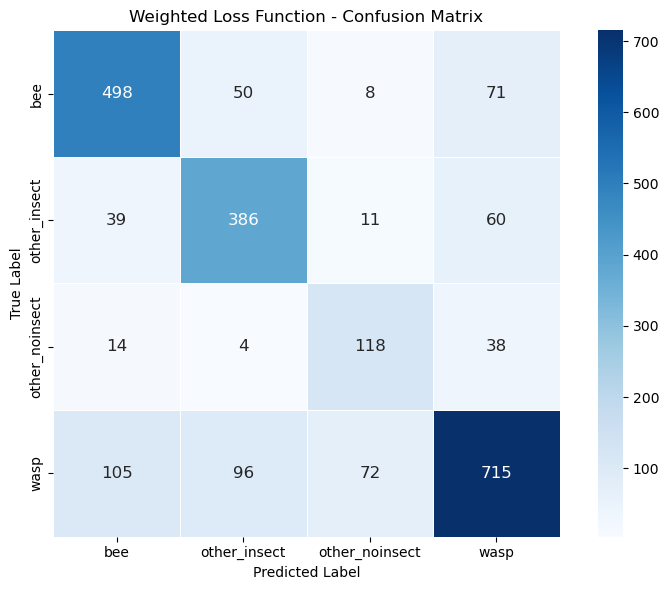


Per-class Accuracy:
  bee: 0.794
  other_insect: 0.778
  other_noinsect: 0.678
  wasp: 0.724


In [11]:
def detailed_evaluation(model, data_module, trainer, model_name):
    """Perform detailed evaluation with metrics appropriate for imbalanced datasets"""

    # Get predictions on validation set
    model.eval()
    all_preds = []
    all_labels = []

    val_loader = data_module.val_dataloader()
    device = next(model.parameters()).device

    with torch.no_grad():
        for batch in val_loader:
            images, labels = batch
            images = images.to(device)

            outputs = model(images)
            _, preds = torch.max(outputs, 1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.numpy())

    # Get class names
    class_names, _ = data_module.get_class_info()

    print(f"\n{model_name} - Detailed Evaluation:")
    print("=" * 50)

    # Classification report
    report = classification_report(
        all_labels, all_preds, target_names=class_names, digits=3, zero_division=0
    )
    print("Classification Report:")
    print(report)

    # Confusion Matrix
    cm = confusion_matrix(all_labels, all_preds)

    plt.figure(figsize=(8, 6))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=class_names,
        yticklabels=class_names,
        cbar=True,
        square=True,
        linewidths=0.5,
        annot_kws={"size": 12},
    )
    plt.title(f"{model_name} - Confusion Matrix")
    plt.ylabel("True Label")
    plt.xlabel("Predicted Label")
    plt.tight_layout()
    plt.show()

    # Calculate per-class accuracy
    per_class_acc = cm.diagonal() / cm.sum(axis=1)
    print("\nPer-class Accuracy:")
    for i, class_name in enumerate(class_names):
        print(f"  {class_name}: {per_class_acc[i]:.3f}")

    return {
        "predictions": all_preds,
        "labels": all_labels,
        "confusion_matrix": cm,
        "per_class_accuracy": per_class_acc,
    }


# Evaluate all three models
print("\n" + "=" * 80)
print("COMPREHENSIVE MODEL COMPARISON")
print("=" * 80)

baseline_eval = detailed_evaluation(
    baseline_model,
    data_module_unbalanced,
    baseline_trainer,
    "Baseline (No Imbalance Handling)",
)
weighted_eval = detailed_evaluation(
    weighted_model, data_module_weighted, weighted_trainer, "Weighted Sampling"
)
weighted_loss_eval = detailed_evaluation(
    weighted_loss_model,
    data_module_unbalanced,
    weighted_loss_trainer,
    "Weighted Loss Function",
)

## 9. Summary

Let's create a quick summary of all three approaches:

In [12]:
# Create summary comparison
class_names, class_counts = data_module_unbalanced.get_class_info()

print("\n" + "=" * 80)
print("SUMMARY COMPARISON")
print("=" * 80)

print("\nPer-Class Accuracy Comparison:")
print(f"{'Class':<15} {'Baseline':<12} {'Weighted Samp':<14} {'Weighted Loss':<13}")
print("-" * 60)

for i, class_name in enumerate(class_names):
    baseline_acc = baseline_eval["per_class_accuracy"][i]
    weighted_acc = weighted_eval["per_class_accuracy"][i]
    weighted_loss_acc = weighted_loss_eval["per_class_accuracy"][i]

    print(
        f"{class_name:<15} {baseline_acc:<12.3f} {weighted_acc:<14.3f} {weighted_loss_acc:<13.3f}"
    )

# Calculate macro and micro averages
print(f"\n{'Metric':<20} {'Baseline':<12} {'Weighted Samp':<14} {'Weighted Loss':<13}")
print("-" * 65)

# Macro average (unweighted mean of per-class accuracies)
baseline_macro = np.mean(baseline_eval["per_class_accuracy"])
weighted_macro = np.mean(weighted_eval["per_class_accuracy"])
weighted_loss_macro = np.mean(weighted_loss_eval["per_class_accuracy"])

print(
    f"{'Macro Avg Accuracy':<20} {baseline_macro:<12.3f} {weighted_macro:<14.3f} {weighted_loss_macro:<13.3f}"
)

# Overall accuracy
baseline_overall = np.sum(np.diag(baseline_eval["confusion_matrix"])) / np.sum(
    baseline_eval["confusion_matrix"]
)
weighted_overall = np.sum(np.diag(weighted_eval["confusion_matrix"])) / np.sum(
    weighted_eval["confusion_matrix"]
)
weighted_loss_overall = np.sum(
    np.diag(weighted_loss_eval["confusion_matrix"])
) / np.sum(weighted_loss_eval["confusion_matrix"])

print(
    f"{'Overall Accuracy':<20} {baseline_overall:<12.3f} {weighted_overall:<14.3f} {weighted_loss_overall:<13.3f}"
)


SUMMARY COMPARISON

Per-Class Accuracy Comparison:
Class           Baseline     Weighted Samp  Weighted Loss
------------------------------------------------------------
bee             0.839        0.791          0.794        
other_insect    0.702        0.730          0.778        
other_noinsect  0.460        0.569          0.678        
wasp            0.753        0.751          0.724        

Metric               Baseline     Weighted Samp  Weighted Loss
-----------------------------------------------------------------
Macro Avg Accuracy   0.688        0.710          0.744        
Overall Accuracy     0.743        0.744          0.751        


## 10. Key Takeaways

Based on our experiments with handling class imbalance, here are the key insights:

### Techniques Compared:

1. **Baseline (No Imbalance Handling)**:
   - Uses the natural, imbalanced distribution
   - Typically biased toward majority classes
   - May achieve high overall accuracy but poor performance on minority classes

2. **Weighted Random Sampling**:
   - Oversamples minority classes during training
   - Ensures the model sees a balanced distribution of examples
   - Can improve performance on minority classes

3. **Weighted Loss Function**:
   - Applies higher penalty for misclassifying minority classes
   - Keeps the original data distribution but adjusts learning signal
   - Often provides a good balance between majority and minority class performance

### When to Use Each Technique:

- **Weighted Sampling**: When you have sufficient data and computational resources for oversampling
- **Weighted Loss**: When you want to maintain the original data distribution but adjust the learning process
- **Combination**: Sometimes combining both techniques can yield the best results

### Important Considerations:

1. **Evaluation Metrics**: For imbalanced datasets, focus on:
   - Per-class accuracy
   - Macro-averaged metrics (treats all classes equally)
   - Precision, recall, and F1-score for each class

2. **Real-world Impact**: Consider the cost of misclassifying different classes. Sometimes it's more important to correctly identify rare but critical cases.

3. **Data Quality**: Ensure minority classes have sufficient diversity and quality examples.

## 11. Experiment on Your Own

Try modifying the following parameters to see how they affect performance:

1. **Class weights**: Experiment with different weighting schemes
2. **Sampling strategy**: Try different oversampling ratios
3. **Model architecture**: Add more layers or change dropout rates
4. **Learning rate**: Different learning rates for imbalanced data
5. **Batch size**: Smaller batches might help with minority classes

Use the code cells below to run your own experiments:

In [ ]:
# Experiment cell - modify parameters here
# Example: Try different class weights

# Calculate different class weights (more aggressive)
aggressive_weights = []
for class_name in class_names:
    weight = (
        total_samples / class_counts[class_name]
    ) ** 0.5  # Square root for less aggressive weighting
    aggressive_weights.append(weight)

aggressive_weights_tensor = torch.tensor(aggressive_weights, dtype=torch.float32)
print(f"Aggressive class weights: {aggressive_weights_tensor}")

# You can create and train a new model with these weights here
# ...

In [ ]:
# Additional experiment cell for your own modifications
# Try different batch sizes, learning rates, or architectures

----
## Push changes to GitHub <img src="images/push_to_github.png" alt="Push to GitHub icon" align="right" width=150>

 Remember to **add**, **commit**, and **push** the changes you have made to this notebook to GitHub to keep your repository in sync.

In Jupyter, those are done in the git tab on the left. In Google Colab, use File > Save a copy in GitHub.